# Stock Price Forecasting

This project explores machine learning techniques to predict stock price movements based on historical data. It includes data preprocessing, feature engineering model training, evaluation, and visualization of results. The goal is to analyze patterns in stock prices and build predictive models that can provide useful insights for financial forecasting.

---

**Models:**
- ARIMA (Statistical Model)
- XGBoost (ML Model)
- LSTM (Deep Learning Model)

---

**Author:** Md. Tushar Shihab<br>
**Objective:** Predict next-day closing price using optimized models

# Imports Libraries & Configuration

In [1]:

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Core Python libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn utilities for evaluation and preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Machine Learning models and optimization
import xgboost as xgb
import optuna

# ARIMA models for time series forecasting
from pmdarima import auto_arima
from pmdarima.arima import ARIMA

# Deep Learning with Keras (LSTM for sequential data like stock prices)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Utility imports
import datetime
import os

# Reproducibility setup
np.random.seed(42)
tf.random.set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Load and Prepare Data

In [2]:
# The stock we'll use for this analysis
stock = 'AAPL'

# data range for stock data
start = '2012-01-01'
end = '2024-12-31'

# Download stock data using yfinance
data = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
# display data
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.345170,12.383296,12.278226,12.290234,302220800
2012-01-04,12.411515,12.448741,12.286632,12.308246,260022000
2012-01-05,12.549311,12.564921,12.388402,12.456849,271269600
2012-01-06,12.680497,12.691004,12.585033,12.601544,318292800
2012-01-09,12.660384,12.841105,12.648976,12.773561,394024400


In [4]:
# shape of the dataset
data.shape

(3269, 5)

## Standardize Dataset

In [5]:
# reset index to make Date a column
data.reset_index(inplace=True)

In [6]:
# flatten the column names (remove multi-level, unnecessary tags)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

In [7]:
data.columns

Index(['Date', 'CloseAAPL', 'HighAAPL', 'LowAAPL', 'OpenAAPL', 'VolumeAAPL'], dtype='object')

In [8]:
# rename columns to clean names
data.rename(columns={
    'CloseAAPL': 'Close',
    'HighAAPL': 'High',
    'LowAAPL': 'Low',
    'OpenAAPL': 'Open',
    'VolumeAAPL': 'Volume'
}, inplace=True)

In [9]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2012-01-03,12.345170,12.383296,12.278226,12.290234,302220800
1,2012-01-04,12.411515,12.448741,12.286632,12.308246,260022000
2,2012-01-05,12.549311,12.564921,12.388402,12.456849,271269600
3,2012-01-06,12.680497,12.691004,12.585033,12.601544,318292800
4,2012-01-09,12.660384,12.841105,12.648976,12.773561,394024400


In [10]:
# fix date columns if there is any inconsistent or unusual dates
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

## Understand the dataset

In [11]:
# descriptive statistics about the Data
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3269,2018-07-01 23:14:37.699602432,2012-01-03 00:00:00,2015-04-06 00:00:00,2018-07-02 00:00:00,2021-09-29 00:00:00,2024-12-30 00:00:00,NaN
Close,3269.0,76.242169,11.896804,23.223898,41.571022,139.147583,258.103729,65.849787
High,3269.0,76.981344,12.173106,23.351521,41.837841,140.838086,259.179926,66.457532
Low,3269.0,75.423667,11.731388,23.031581,41.176438,136.593817,256.718662,65.147894
Open,3269.0,76.176454,11.818818,23.199496,41.550743,139.084476,257.276679,65.767061
Volume,3269.0,181275898.348119,23234700.0,79592600.0,121517600.0,216229200.0,1506120000.0,166798882.858728


In [12]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3269 non-null   datetime64[ns]
 1   Close   3269 non-null   float64       
 2   High    3269 non-null   float64       
 3   Low     3269 non-null   float64       
 4   Open    3269 non-null   float64       
 5   Volume  3269 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 153.4 KB


# Analytical Plots

## Closing Price

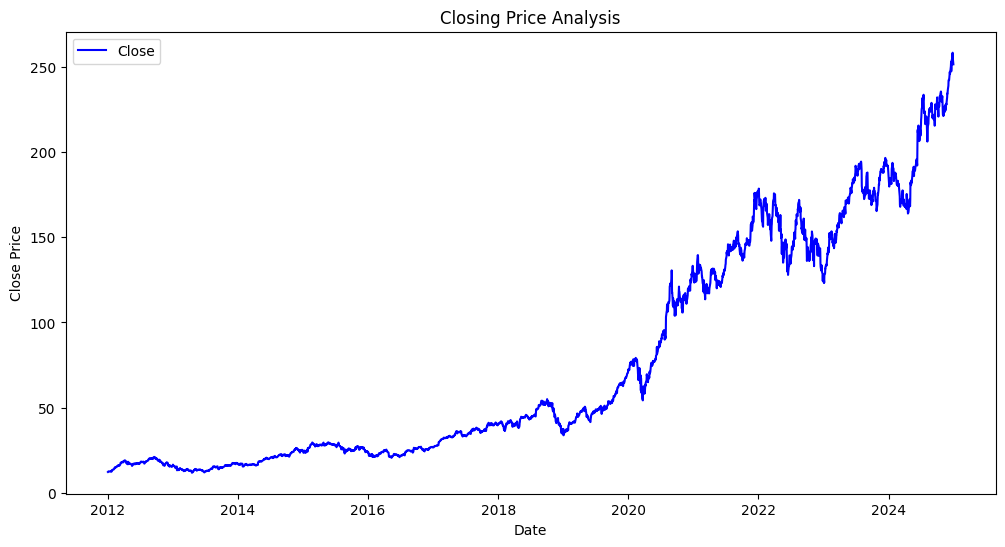

In [13]:
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.title(f"Closing Price Analysis")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

## Volume of Sales

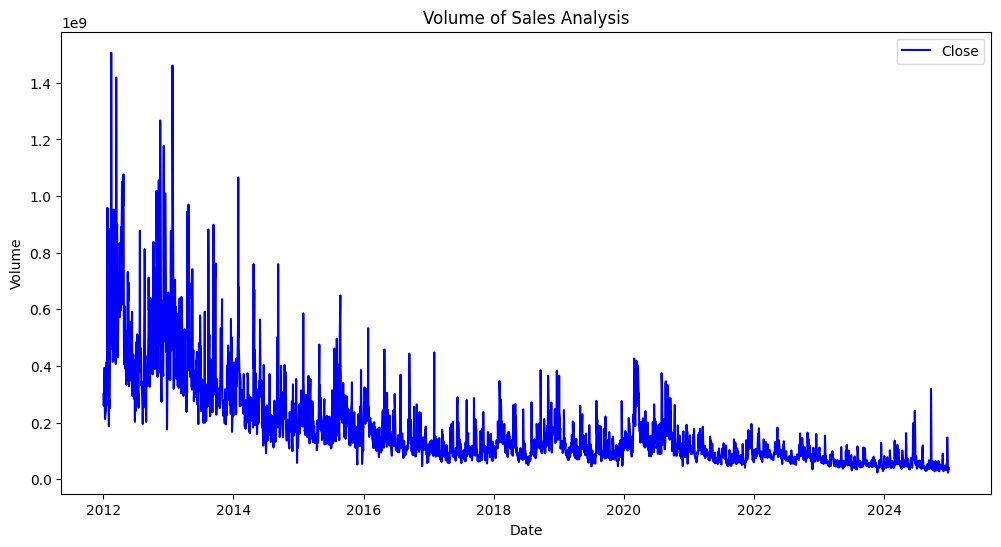

In [15]:
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data['Date'], data['Volume'], label='Close', color='blue')
plt.title(f"Volume of Sales Analysis")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

# Moving Average of the Stock

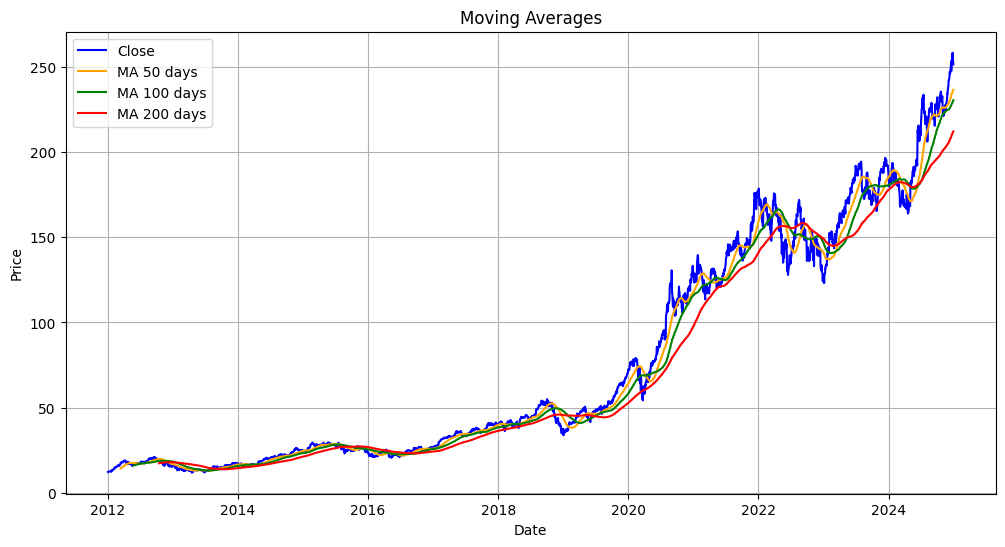

In [16]:
# define moving averages
ma_days = [50, 100, 200]
ma_colors = ['orange', 'green', 'red']

# calculate moving averages
for ma in ma_days:
    column_name = f"MA_{ma}"
    data[column_name] = data['Close'].rolling(ma).mean()

# plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close', color='blue')

# plot each moving average
for ma, color in zip(ma_days, ma_colors):
    plt.plot(data['Date'], data[f"MA_{ma}"], label=f"MA {ma} days", color=color)

plt.title(f"Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Daily return of the stock on average

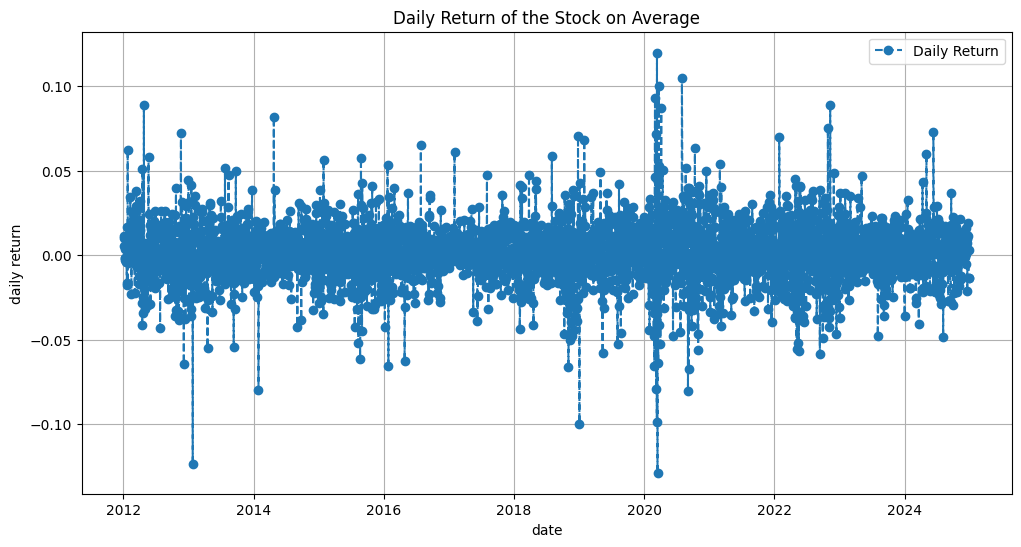

In [17]:
# calculate daily return
data['DailyReturn'] = data['Close'].pct_change()

# plot daily return percentage
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['DailyReturn'], linestyle='--', marker='o', label='Daily Return')

plt.title(f"Daily Return of the Stock on Average")
plt.xlabel("date")
plt.ylabel("daily return")
plt.legend()
plt.grid(True)
plt.show()
